<a href="https://colab.research.google.com/github/roderickperez/PINN/blob/master/PINN_1D_Poisson_(Dirichlet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN
Tutorial 3: Poisson (1D) Dirichlet | Juan Toscano (Github: jdtoscano94)

https://github.com/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/3_Poisson1D_Dirichlet.ipynb

## 0. Install Libraries

In [1]:
! pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=2db703c498836ea006485cb63b0dbaaab046d9234ae33d627dbc9ddc0fef1d2a
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


## 1. Import Libraries

In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

## 2. Setup parameters and constants

In [4]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [38]:
steps = 100
lr = 1e-3

layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
min=-1
max=1
total_points=500
#Nu: Number of training points (2 as we only have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nu = 2
Nf = 50

## 3. Define Function

###  Laplace Operator ($\nabla^{2}$)

What function has as a derivative $cos(X)$?

$$ \nabla = u_{xx}+u_{yy} = \frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} $$

**Harmonic Functions**

$$ \nabla u = 0$$

Since they are smooth. Boundary conditions: rate or the value. It is necessary to solve all the problems at the same time.

**Poisson Equation**
$$ \nabla u = f(x)$$

**Problem**

For the case that

$$ - \nabla u = \pi^2sin(\pi x)$$

**Boundary Conditions**

$$ u(-1) = 0$$

$$ u(0) = 0$$

**Exact solution**

$$u(x) = sin(\pi x)$$

**PDE**

$$ - \nabla u = \pi^2sin(\pi x)$$

$$ u_{xx} = - \pi^2 sin(\pi x)$$

$$ \frac{\partial ^2 u}{\partial x^2} = - \pi^2 sin(\pi x)$$

Residuals:

$$0 = \frac{\partial ^2 u}{\partial x^2}+\pi^2 sin(\pi x)$$

Note: $NN(X) \approx u(x)$ so:

$$\frac{\partial ^2 NN}{\partial x^2}\approx \frac{\partial ^2 u}{\partial x^2}$$

therefore,

$$f = \frac{\partial ^2 NN}{\partial x^2}+\pi^2 sin(\pi x) → 0$$

**Initial Conditions (Direchlet BC)**

$$ u(-1) = 0$$

$$ u(0) = 0$$

A function that describe the boundary conditions:
$$f_{BC} = 1 - \left | x \right |$$

---

Note 
$f_{BC}$ is not the answer to our PDE, but it helps us describe the boundary condition (Generate data).

This function satisfies the boundry conditions. The same as the real one (To ease the data generation), but we may not have it.

In [39]:
def f_BC(x):
  return 1-torch.abs(x)

In [40]:
def f_real(x):
  return torch.sin(np.pi*x)

The PDE equation is used to get the residual in the Neural Network.

In [41]:
def PDE(x):
  return -1*(np.pi**2)*torch.sin(np.pi*x)

## 4. Define Network Architecture

Following the PyTorch Network Architecture
```python
class networkName(nn.Module):

    def __init__(self, ...):
        super(networkName, self).__init__()
        # Define Network layers
        self.layer1 = nn.XXXX(...)
        self.layer2 = nn.XXXX(...)
        ...
        self.layern = nn.XXXX(...)

    def forward(self, x):
        out = self.layer1
        out = self.layer2
        ...
        out = self.layern

        return out

# Call the model
model = networkName(...)

# Define loss
loss = nn.XXXLoss()
```

In this case, we will follow the following architecture:

*   Activation Function: tanh
*   Loss Function: MSE
*   Initialise neural network as a list using `nn.Modulelist()`


In [42]:
class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0] #first derivative
      f_xx=autograd.grad(f_x,g,torch.ones([x_PDE.shape[0],1]).to(device), create_graph=True)[0]#second derivative
      return self.loss_function(f_xx,PDE(g))
      
    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

## 5. Data

Generate the analytical solution over the full domain

In [43]:
x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y = f_real(x)
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


### Plot Results

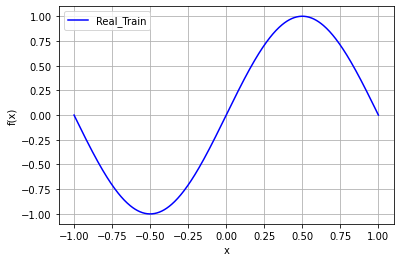

In [44]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper left')

### Set Boundary conditions:


In [45]:
BC_1=x[0,:]
BC_2=x[-1,:]

In [46]:
print('Location in x of Boundary Condition 1: ', BC_1.item())

Location in x of Boundary Condition 1:  -1.0


In [47]:
print('Location in x of Boundary Condition 2: ', BC_2.item())

Location in x of Boundary Condition 2:  1.0


### Total Training points
$$total = BC_{1}+BC_{2}$$


In [48]:
all_train=torch.vstack([BC_1,BC_2])

In [49]:
print('Total Boundary Condition Points: ', len(all_train))

Total Boundary Condition Points:  2


### Select Nu points


In [50]:
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]

In [51]:
print('Total Boundary Condition Points: ', len(x_BC))

Total Boundary Condition Points:  2


In [52]:
# Evaluate the Boundary Conditions in Function
x_BC=f_BC(x_BC).to(device)

In [53]:
print('Result of Evaluate Boundary Condition 1: ', x_BC[0].item())
print('Result of Evaluate Boundary Condition 2: ', x_BC[1].item())

Result of Evaluate Boundary Condition 1:  0.0
Result of Evaluate Boundary Condition 2:  0.0


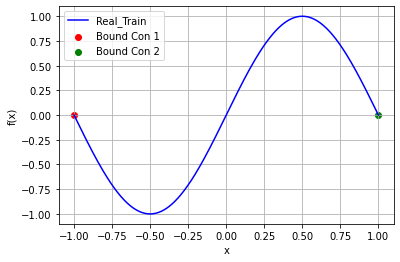

In [54]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
ax1.scatter(BC_1.detach().numpy(),x_BC[0],color='red',label='Bound Con 1')
ax1.scatter(BC_2.detach().numpy(),x_BC[1],color='green',label='Bound Con 2')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper left')

### Select Nf points
Latin Hypercube sampling for collocation points 

In [55]:
# Positions in X to evaluate (Nf + BC)
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC))

Data points

`Nf` is the number of collocation points, corresponding to the number of points to evaluate the function.

In [56]:
print('Total Evaluation Points (X): ', x_PDE.shape[0])

Total Evaluation Points (X):  52


In [63]:
# Evaluate the Boundary Conditions in Function
y_DC = f_BC(x_PDE).to(device)

In [64]:
# Evaluate training points in Real Function
y_real = f_real(x_PDE).to(device)

In [65]:
print('Total Evaluated BC Points (Y): ', len(y_DC))
print('Total Evaluated Real Function Points (Y): ', len(y_real))

Total Evaluated BC Points (Y):  52
Total Evaluated Real Function Points (Y):  52


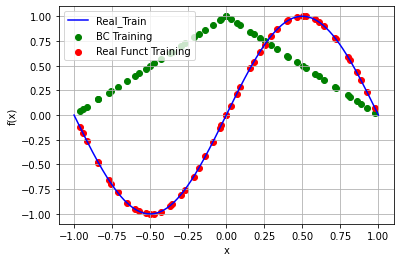

In [68]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
ax1.scatter(x_PDE.detach().numpy(),y_DC.detach().numpy(),color='green',label='BC Training')
ax1.scatter(x_PDE.detach().numpy(),y_real.detach().numpy(),color='red',label='Real Funct Training')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper left')

In [57]:
x_PDE.shape

torch.Size([52, 1])

In [58]:
y_BC=f_BC(x_BC).to(device)

## 6. Train Network

In [18]:
# Prepare model
torch.manual_seed(123)
x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)

In [19]:
# Create Model and Show Summary
model = FCN(layers)
model.to(device)

print(model)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [20]:
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

In [21]:
model.lossBC(x_BC,y_BC)

tensor(0.0160, grad_fn=<MseLossBackward0>)

### 6.1 Training Loop

In [22]:
l = []

for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_BC,y_BC,x_PDE)# use mean squared error
    l.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(47.8740, grad_fn=<AddBackward0>)
tensor(30.7291, grad_fn=<AddBackward0>)
tensor(18.1121, grad_fn=<AddBackward0>)
tensor(13.7264, grad_fn=<AddBackward0>)
tensor(11.5135, grad_fn=<AddBackward0>)
tensor(9.4213, grad_fn=<AddBackward0>)
tensor(6.5952, grad_fn=<AddBackward0>)
tensor(3.5637, grad_fn=<AddBackward0>)
tensor(1.1808, grad_fn=<AddBackward0>)
tensor(0.2400, grad_fn=<AddBackward0>)


## 6. Plot Functions

In [23]:
# Function
yh=model(x.to(device))
y=f_real(x)

In [72]:
yh_=model(x_PDE.to(device))

In [73]:
len(yh_)

52

## Error


In [24]:
print(model.lossBC(x.to(device),f_real(x).to(device)))

tensor(0.0355, grad_fn=<MseLossBackward0>)


## Derivative

In [25]:
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

### Detach from GPU

In [74]:
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()

In [76]:
print('x_PDE size = ', len(x_PDE))
print('yh_ size = ', len(yh_))
print('y_plot size = ', len(y_plot))
print('yh_plot size = ', len(yh_plot))
print('f_x_plot size = ', len(f_x_plot))

x_PDE size =  52
yh_ size =  52
y_plot size =  500
yh_plot size =  500
f_x_plot size =  500


## 7. Plot Results

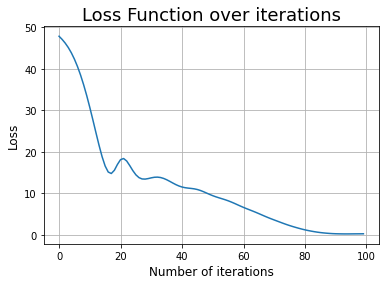

In [27]:
plt.plot(l)
plt.xlabel('Number of iterations', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Loss Function over iterations', fontsize = 18)
plt.grid()

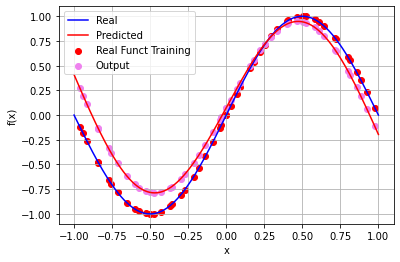

In [78]:
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real')
ax1.plot(x,yh_plot,color='red',label='Predicted')
#ax1.plot(x,f_x_plot,color='green',label='Derivative')
#ax1.scatter(x_PDE.detach().numpy(),y_DC.detach().numpy(),color='green',label='BC Training')
ax1.scatter(x_PDE.detach().numpy(),y_real.detach().numpy(),color='red',label='Real Funct Training')

ax1.scatter(x_PDE.detach().cpu().numpy(),yh_.detach().cpu().numpy(),color='violet',label='Output')

ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')
ax1.grid()

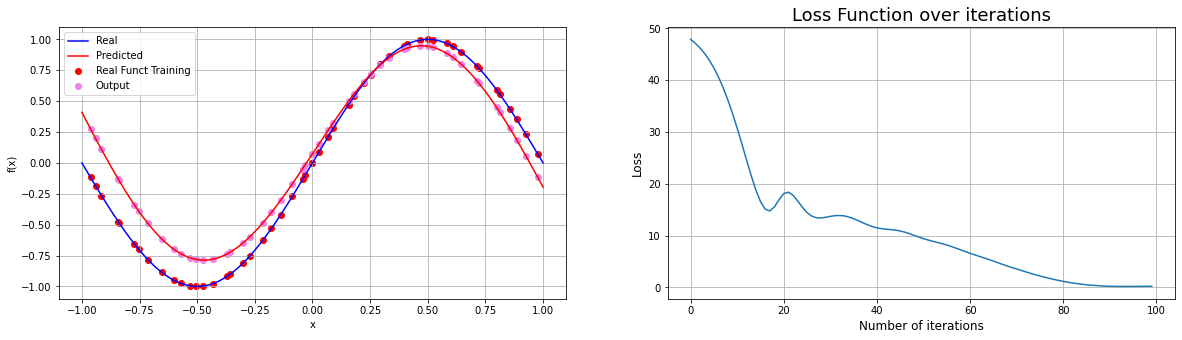

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(x,y_plot,color='blue',label='Real')
ax1.plot(x,yh_plot,color='red',label='Predicted')
#ax1.plot(x,f_x_plot,color='green',label='Derivative')
#ax1.scatter(x_PDE.detach().numpy(),y_DC.detach().numpy(),color='green',label='BC Training')
ax1.scatter(x_PDE.detach().numpy(),y_real.detach().numpy(),color='red',label='Real Funct Training')
ax1.scatter(x_PDE.detach().cpu().numpy(),yh_.detach().cpu().numpy(),color='violet',label='Output')

ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')
ax1.grid()

##############
ax2.plot(l)
ax2.set_xlabel('Number of iterations', fontsize = 12)
ax2.set_ylabel('Loss', fontsize = 12)
ax2.set_title('Loss Function over iterations', fontsize = 18)
ax2.grid()